# Evaluation demo of SPN

In [1]:
%matplotlib inline

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from spn import object_localization
import experiment.util as utils

plt.rcParams["figure.figsize"] = (8,8)

## Point Localization

* Load ground truth and model.

In [3]:
DATA_ROOT = '/root/Dataset/VOCdevkit/VOC2007'
ground_truth = utils.load_ground_truth_voc(DATA_ROOT, 'test')

model_path = './logs/voc2007/model.pth.tar'
model_dict = utils.load_model_voc(model_path)

* Extract points and evaluate.

In [4]:
predictions = []
for img_idx in tqdm(range(len(ground_truth['image_list']))):
    image_name = os.path.join(DATA_ROOT, 'JPEGImages', ground_truth['image_list'][img_idx] + '.jpg')
    _, input_var = utils.load_image_voc(image_name)
    gt_labels = (ground_truth['gt_labels'][img_idx] >= 0).nonzero()[0]
    preds, labels = object_localization(model_dict, input_var, location_type='point', gt_labels=gt_labels, multi_objects=False)
    predictions += [(img_idx,) + p for p in preds]

print('Pointing accuracy: {:.2f}'.format(utils.pointing(np.array(predictions), ground_truth) * 100.))

100%|██████████| 4952/4952 [03:07<00:00, 30.31it/s]


Pointing accuracy: 87.47


* Visualization

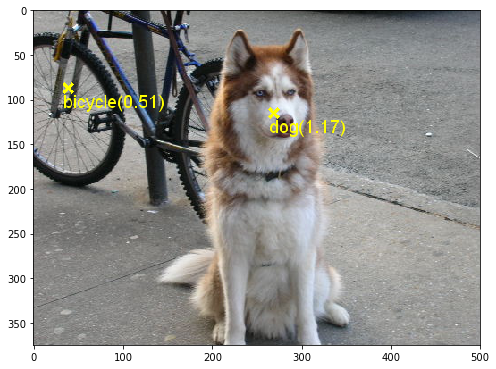

In [5]:
image_name = 'evaluation/sample1.jpg'
categories = ['dog', 'bicycle']
_, input_var = utils.load_image_voc(image_name)
preds, labels = object_localization(model_dict, input_var, location_type='point', gt_labels=[ground_truth['class_names'].index(c) for c in categories], multi_objects=False)
img = Image.open(image_name)
img_draw = utils.draw_points(img, np.array(preds), ground_truth['class_names'])
plt.imshow(img_draw)

## Bounding box localization

We perform bounding box localization on ImageNet and Pascal VOC.

### LocErr

Weakly supervised localization results on ImageNet 2014 localization task. See this [paper](https://arxiv.org/abs/1608.00507) for details.

* Load ground truth and model. You need to download the model [SP_GoogleNet_ImageNet](https://1drv.ms/u/s!AvBFM3T6JM8WhmRqYC3nyBeagbsJ) and [annotations](http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_bbox_val_v3.tgz) into folder `imagenet_eval`.

In [6]:
DATA_ROOT='./evaluation/imagenet_eval'
ground_truth_imagenet = utils.load_ground_truth_imagenet(DATA_ROOT)

model_path = os.path.join(DATA_ROOT, 'SP_GoogleNet_ImageNet.pt')
model_dict = utils.load_model_imagenet(model_path)

* Extract bboxes and evaluate.

In [7]:
image_dir = '../data/ILSVRC2012/val/'
predictions = []
for img_idx in tqdm(range(len(ground_truth_imagenet['image_list']))):
    image_name = os.path.join(image_dir, ground_truth_imagenet['image_list'][img_idx].strip() + '.JPEG')
    _, input_var = utils.load_image_imagenet(image_name)
    gt_labels = [ground_truth_imagenet['gt_labels'][img_idx]]
    preds, labels = object_localization(model_dict, input_var, location_type='bbox', gt_labels=gt_labels, multi_objects=False)
    predictions += [(img_idx,) + p for p in preds]

print("LocErr: {:.2f}".format(utils.locerr(np.array(predictions), ground_truth_imagenet) * 100.))

100%|██████████| 50000/50000 [45:30<00:00, 19.55it/s]


LocErr: 36.63


* Visualization

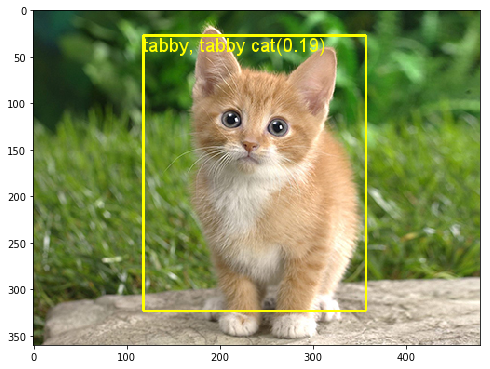

In [8]:
image_name = './evaluation/sample2.jpg'
categories = ['n02123045']
_, input_var = utils.load_image_imagenet(image_name)
preds, labels = object_localization(model_dict, input_var, location_type='bbox', gt_labels=[ground_truth_imagenet['class_words'].index(c) for c in categories])
img = Image.open(image_name)
img_draw = utils.draw_bboxes(img, np.array(preds), ground_truth_imagenet['class_names'])
plt.imshow(img_draw)

### Corloc

* Load ground truth and model.

In [9]:
DATA_ROOT = '/root/Dataset/VOCdevkit/VOC2007'
ground_truth = utils.load_ground_truth_voc(DATA_ROOT, 'trainval')

model_path = './logs/voc2007/model.pth.tar'
model_dict = utils.load_model_voc(model_path, True)

* Extract bboxes and evaluate.

In [10]:
predictions = []
for img_idx in tqdm(range(len(ground_truth['image_list']))):
    image_name = os.path.join(DATA_ROOT, 'JPEGImages', ground_truth['image_list'][img_idx] + '.jpg')
    _, input_var = utils.load_image_voc(image_name)
    preds, labels = object_localization(model_dict, input_var, location_type='bbox', gt_labels=(ground_truth['gt_labels'][img_idx] == 1).nonzero()[0], nms_threshold=0.7)
    predictions += [(img_idx,) + p for p in preds]

print("Corloc: {:.2f}".format(utils.corloc(np.array(predictions), ground_truth) * 100.))

100%|██████████| 5011/5011 [18:16<00:00,  4.63it/s]


Corloc: 60.50


* Visualization

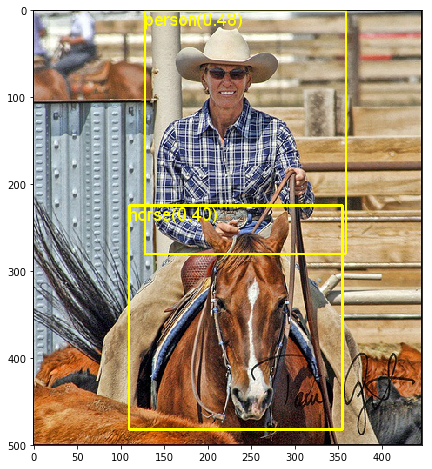

In [11]:
image_name = './evaluation/sample3.jpg'
_, input_var = utils.load_image_voc(image_name)
preds, labels = object_localization(model_dict, input_var, location_type='bbox', gt_labels=[ground_truth['class_names'].index(c) for c in ['person', 'horse']])
img = Image.open(image_name)
img_draw = utils.draw_bboxes(img, np.array(preds), ground_truth['class_names'])
plt.imshow(img_draw)